Notebook for training on relative wind angle features  

- Need to handle different time frequency data. Ex, fit data with 3 second freqeuency will be 15 second total interval.

Input features:
Concatenation of 5 time-series datapoints, each having:
- Speed of rider (m/s)
- Elevation delta from previous point (meters)
- Wind speed (m/s)
- Wind direction wrt rider direction (degrees)

Output labels: - 5 second power in watts (target)

In [1]:
import time
import datetime
import os
import sys
from typing import List
import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from wind2watts.data.datasets import WindAnglePowerDataset
from wind2watts.fit.util import fit_to_df

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Load Data

In [3]:
activities = []
data_dir = '../../data/dataframes/strava_export/'
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(data_dir, file))
    df['name'] = file.split('.')[0]
    activities.append(df)

#### Construct Datasets

In [4]:
from sklearn.model_selection import train_test_split
train_activities, test_activities = train_test_split(activities, test_size=0.2, random_state=42)

In [5]:
window_size = 5
batch_size = 32

In [6]:
from torch.utils.data import DataLoader

train_dataset = WindAnglePowerDataset(
    train_activities,
    window_size=window_size,
    device=device,
)

val_dataset = WindAnglePowerDataset(
    test_activities,
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
)

test_dataloaders = [DataLoader(WindAnglePowerDataset(
    [activity],
    window_size=window_size,
    window_scaler=train_dataset.window_scaler,
    power_scaler=train_dataset.power_scaler,
    device=device,
), shuffle = False) for activity in test_activities]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

len(train_dataloader)

13151

#### Define Model

In [7]:
import torch.nn as nn
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
       super(SimpleRNN, self).__init__() 
       self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
       self.fc1 = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.fc1(output[:, -1, :])
        return output

In [8]:
learning_rate = 1e-3 
epochs = 50 

In [12]:
model = SimpleRNN(input_size = 4, hidden_size = 32)
model.train()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model.to(device)
criterion.to(device)

MSELoss()

In [21]:
model_dir = '../../training_checkpoints/rel_wind_angle/simplernn_v1p0/'
os.makedirs(model_dir, exist_ok=True)
min_loss = float('inf')

#### Training Loop

In [14]:
train_losses = []
val_losses = []
time_loading = 0
time_inferring = 0
for epoch in range(epochs):
    batch_loss = 0
    now = time.time()
    for i, (x, y) in enumerate(train_dataloader):
        time_loading += time.time() - now
        optimizer.zero_grad()
        now = time.time()
        output = model(x)
        time_inferring += time.time() - now
        loss = criterion(output, y)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        now = time.time()
    train_loss = batch_loss / len(train_dataloader)
    train_losses.append(train_loss)
    
    with torch.no_grad():
        val_loss = 0
        for i, (x, y) in enumerate(val_dataloader):
            output = model(x)
            loss = criterion(output, y)
            val_loss += loss.item()
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
    
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pt'))

    print(f'Epoch: {epoch}, Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

Epoch: 0, Loss: 0.008348523771713105, Val Loss: 0.007705132618275845
Epoch: 1, Loss: 0.007639997293915577, Val Loss: 0.00863273288129943
Epoch: 2, Loss: 0.007233746486862467, Val Loss: 0.007350933944018414
Epoch: 3, Loss: 0.00715264968925515, Val Loss: 0.006985621537119044
Epoch: 4, Loss: 0.007074906130582428, Val Loss: 0.006877807001158744
Epoch: 5, Loss: 0.007007454101500973, Val Loss: 0.0068105994773487374
Epoch: 6, Loss: 0.0069682162804850225, Val Loss: 0.006900560424233286
Epoch: 7, Loss: 0.006938771569797431, Val Loss: 0.006939446743301771
Epoch: 8, Loss: 0.006911339122092001, Val Loss: 0.007129632443006541
Epoch: 9, Loss: 0.006893019434754391, Val Loss: 0.007023408098220613
Epoch: 10, Loss: 0.006875297939488056, Val Loss: 0.006902441842099413
Epoch: 11, Loss: 0.006863110728379027, Val Loss: 0.006694646627825295
Epoch: 12, Loss: 0.00685135508714781, Val Loss: 0.006689352277225876
Epoch: 13, Loss: 0.00683715299050738, Val Loss: 0.00678930114596509
Epoch: 14, Loss: 0.00682930288337

KeyboardInterrupt: 

In [30]:
joblib.dump(train_dataset.window_scaler, os.path.join(model_dir, "window_scaler.joblib"))
joblib.dump(train_dataset.power_scaler, os.path.join(model_dir, "power_scaler.joblib"))

['../../training_checkpoints/rel_wind_angle/simplernn_v1p0/power_scaler.joblib']

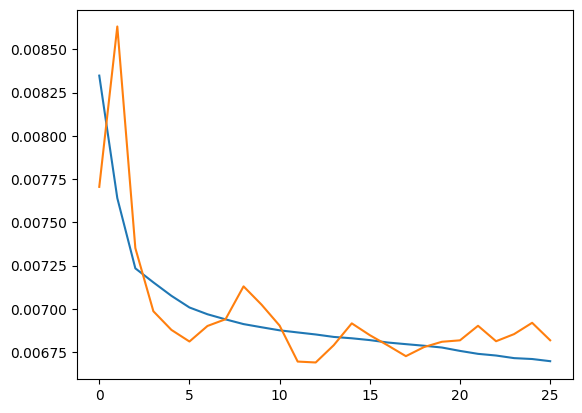

In [15]:
plt.plot(train_losses)
plt.plot(val_losses)

#### Model Eval

In [31]:
best_model = SimpleRNN(4, 32)
best_model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pt')))
best_model.eval()

SimpleRNN(
  (rnn): RNN(4, 32, batch_first=True)
  (fc1): Linear(in_features=32, out_features=1, bias=True)
)

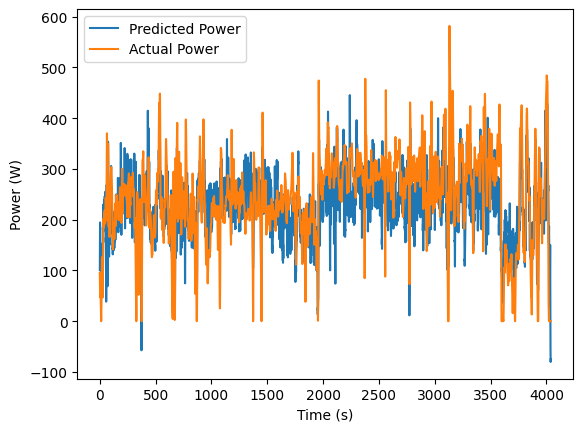

In [32]:
test_activity_dataloader = test_dataloaders[3]

powers = []
pred_powers =  []
for (window, power) in test_activity_dataloader:
    with torch.no_grad():
        power_pred = model(window)
    power_pred = train_dataset.power_scaler.inverse_transform(power_pred.cpu().numpy())
    power = train_dataset.power_scaler.inverse_transform(power.cpu().numpy())
    pred_powers.append(power_pred)
    powers.append(power)

powers = np.array(powers).reshape(-1)
pred_powers = np.array(pred_powers).reshape(-1)


plt.plot(pred_powers, label='Predicted Power')
plt.plot(powers, label='Actual Power')
plt.xlabel('Time (s)')
plt.ylabel('Power (W)')
plt.legend()

In [33]:
print(np.mean(powers))
print(np.mean(pred_powers))

245.26456
228.83437
